In [1]:
import os
os.chdir('..')

In [3]:
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from xgboost import XGBClassifier

In [4]:
import shap
import xgboost
shap.initjs()

In [5]:
from espora import fragmenter

In [6]:
def get_mw(smi):
    mol = Chem.MolFromSmiles(smi)
    return Descriptors.MolWt(mol)

In [7]:
def run_fragrank_frag(smis, threhsold_mw=250):
    fragments = [fragmenter.frag_rec(smi) for smi in tqdm(smis, desc="Fragmenting")]
    fragments = [list(filter(lambda x: get_mw(x) < threhsold_mw, fragment)) for fragment in fragments]
    
    unique_subs = set()
    for subs in chain.from_iterable(fragments):
        unique_subs.add(subs)

    G = nx.Graph()
    for sub in unique_subs:
        G.add_node(sub)

    for i in range(len(smis)):
        for j in range(len(fragments[i])):
            for k in range(j+1, len(fragments[i])):
                sub1 = fragments[i][j]
                sub2 = fragments[i][k]
                if G.has_edge(sub1, sub2):
                    G[sub1][sub2]['weight'] += 1
                else:
                    G.add_edge(sub1, sub2, weight=1)

    pr = nx.pagerank(G)
    return pr

In [8]:
def featurize(smis, top_fragments_mols):
    X_vec = []
    for smi in tqdm(smis, desc="Featurizing"):
        mol = Chem.MolFromSmiles(smi)
        X_vec.append(np.array([mol.HasSubstructMatch(i) for i in top_fragments_mols]).astype(int))
    return np.array(X_vec) 

In [9]:
def model(clf, X_train, X_test, y_train, y_test, top_fragments_mols):
    X_train = featurize(X_train, top_fragments_mols)
    X_test = featurize(X_test, top_fragments_mols)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("recall_score: ", metrics.recall_score(y_test, y_pred))
    print("precision_score: ", metrics.precision_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return (metrics.recall_score(y_test, y_pred), metrics.precision_score(y_test, y_pred))

In [10]:
df = pd.read_csv("./data/Q16620.csv")
# df = pd.read_csv("./data/Q16602.csv")
# df = pd.read_csv("./data/O14649.csv")
# df = pd.read_csv("./data/P04629.csv")
# df = pd.read_csv("./data/A5PKW4.csv")

In [11]:
df["mw"] = df["canonical_smiles"].apply(lambda x: get_mw(x))

In [12]:
df = df[df["mw"] < 800]

In [13]:
df

source            id  \
0      chembl  CHEMBL101311   
1      chembl  CHEMBL103667   
2      chembl  CHEMBL104279   
3      chembl  CHEMBL104333   
4      chembl  CHEMBL104519   
...       ...           ...   
2919  pubchem      47714912   
2920  pubchem       2037329   
2921  pubchem      70341056   
2922  pubchem      24757729   
2923  pubchem       6177647   

                                       canonical_smiles  pchembl_value  \
0      CN(C)CC(O)COc1ccc(Nc2nccc(Nc3cc(Cl)ccc3Cl)n2)cc1           5.50   
1     Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...           6.10   
2     Cn1cc(/C=C2\C(=O)Nc3ccc(S(N)(=O)=O)cc32)c2ccccc21           8.12   
3     COc1ccc2c(c1)c(/C=C1\C(=O)Nc3ccc(S(N)(=O)=O)cc...           6.96   
4     CNS(=O)(=O)c1ccc2c(c1)/C(=C/c1cn(C)c3ccc(OC)cc...           7.39   
...                                                 ...            ...   
2919            O=C(Cc1ccc(F)cc1)NNC(=O)Nc1cccc2cnccc12            NaN   
2920  NC1=NC(c2ccc(F)cc2)C2=C(S1)C(=O)N(c1ccc(Cl)cc1...            NaN   
2921  CCOC(=O)C(CCc1ccccc1)NC(C)C(=O)N1C(C(=O)OCCSCC...            NaN   
2922  COc1c(C#Cc2ccc(N3CCN(S(=O)(=O)NC(C)C(=O)O)CC3)...            NaN   
2923  COc1ccc2oc(-c3cccc(NC(=O)C=Cc4cc(Br)cc(Br)c4OC...            NaN   

      100 uM  10 uM  1 uM  0.1 uM augmentation       mw  
0        1.0    1.0   0.0     0.0          NaN  448.354  
1        1.0    1.0   1.0     0.0          NaN  527.669  
2        1.0    1.0   1.0     1.0          NaN  353.403  
3        1.0    1.0   1.0     0.0          NaN  383.429  
4        1.0    1.0   1.0     1.0          NaN  397.456  
...      ...    ...   ...     ...          ...      ...  
2919     0.0    NaN   NaN     NaN           SE  338.342  
2920     0.0    0.0   0.0     NaN           SE  387.823  
2921     0.0    0.0   0.0     NaN           SE  567.705  
2922     0.0    NaN   NaN     NaN           SE  533.650  
2923     0.0    0.0   0.0     NaN           SE  558.226  

[2906 rows x 10 columns]

In [14]:
X = df.canonical_smiles.values
y = df["100 uM"].values

In [15]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [16]:
sss.get_n_splits(X, y)

3

In [17]:
top_k = 750
precs = []
recalls = []
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f"Fold {i+1}/{sss.get_n_splits(X, y)}: Top K: {top_k}")
    clf = XGBClassifier()
    pr = run_fragrank_frag(X[train_index][y[train_index] == 1.0])
    top_fragments = sorted(pr, key=pr.get, reverse=True)[:top_k]
    top_fragments_mols = [Chem.MolFromSmarts(i) for i in top_fragments]
    r,p = model(clf, X[train_index], X[test_index], y[train_index], y[test_index], top_fragments_mols)
    precs.append(p)        
    recalls.append(r)

Fold 1/3: Top K: 750


Fragmenting:   0%|          | 0/581 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/2324 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/582 [00:00<?, ?it/s]

recall_score:  0.815068493150685
precision_score:  0.8814814814814815
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       436
         1.0       0.88      0.82      0.85       146

    accuracy                           0.93       582
   macro avg       0.91      0.89      0.90       582
weighted avg       0.93      0.93      0.93       582

Fold 2/3: Top K: 750


Fragmenting:   0%|          | 0/581 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/2324 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/582 [00:00<?, ?it/s]

recall_score:  0.8013698630136986
precision_score:  0.9069767441860465
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       436
         1.0       0.91      0.80      0.85       146

    accuracy                           0.93       582
   macro avg       0.92      0.89      0.90       582
weighted avg       0.93      0.93      0.93       582

Fold 3/3: Top K: 750


Fragmenting:   0%|          | 0/581 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/2324 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/582 [00:00<?, ?it/s]

recall_score:  0.8082191780821918
precision_score:  0.921875
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       436
         1.0       0.92      0.81      0.86       146

    accuracy                           0.93       582
   macro avg       0.93      0.89      0.91       582
weighted avg       0.93      0.93      0.93       582



In [18]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in top_fragments], molsPerRow=5, useSVG=True, maxMols=top_k)

In [19]:
pr = run_fragrank_frag(X[train_index][y[train_index] == 1.0])
top_fragments = sorted(pr, key=pr.get, reverse=True)[:top_k]
top_fragments_mols = [Chem.MolFromSmarts(i) for i in top_fragments]

Fragmenting:   0%|          | 0/581 [00:00<?, ?it/s]

In [20]:
X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

In [21]:
clf = XGBClassifier()
X_train = featurize(X_train, top_fragments_mols)
X_test = featurize(X_test, top_fragments_mols)
clf.fit(X_train, y_train)
# create SHAP explainer
explainer = shap.Explainer(clf)
# generate SHAP values for test data
shap_values = explainer(X_test)

Featurizing:   0%|          | 0/2324 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/582 [00:00<?, ?it/s]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


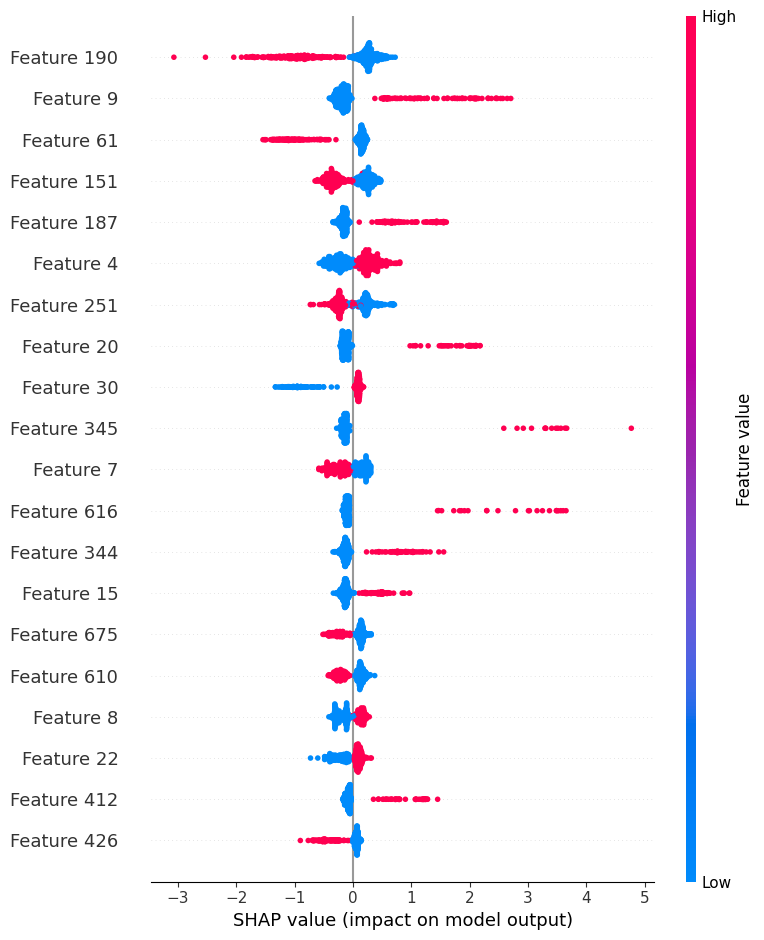

In [22]:
# plot summary plot
shap.summary_plot(shap_values, X_test)

In [57]:
N = 2

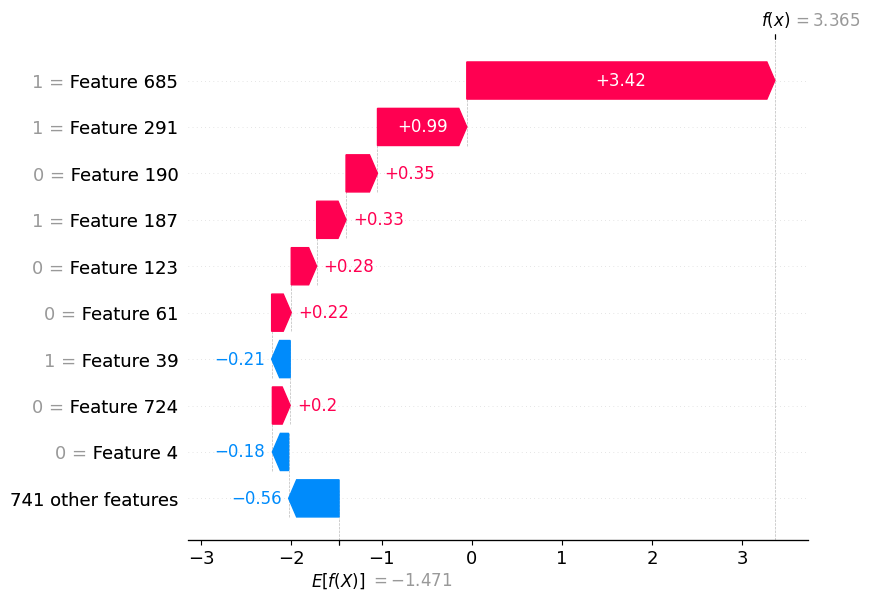

In [58]:
# plot individual instance plot
shap.waterfall_plot(shap_values[N], max_display=10)

In [66]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

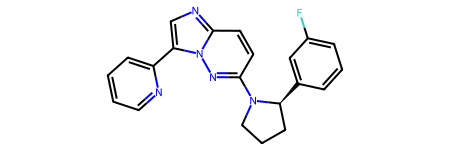

In [67]:
mol = Chem.MolFromSmiles(X[test_index][N])
mol

In [68]:
clf.predict([X_test[N]])

array([1])

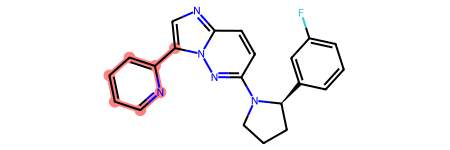

In [72]:
mol.GetSubstructMatches(top_fragments_mols[187])
mol

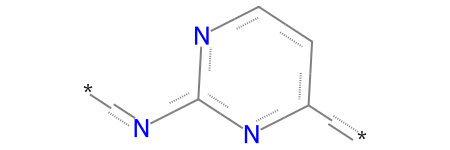

In [79]:
top_fragments_mols[345]